# Bayesian Optimization of a Mitsunobu Reaction

Jason Stevens & Ben Shields

## Mitsunobu Reaction

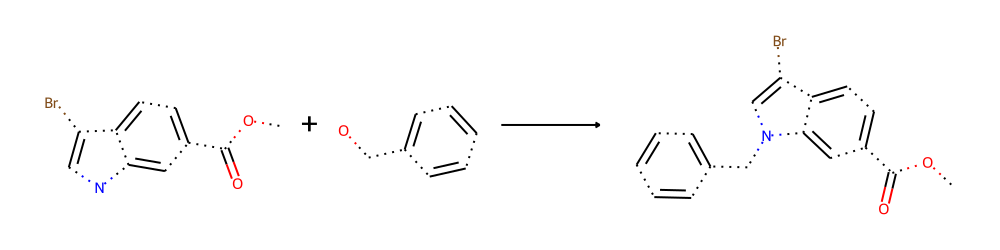

In [1]:
from rdkit.Chem import AllChem, Draw

rxn = AllChem.ReactionFromSmarts('BrC1=CNC2=CC(C(OC)=O)=CC=C21.OCC3=CC=CC=C3>>BrC4=CN(CC5=CC=CC=C5)C6=CC(C(OC)=O)=CC=C64')
Draw.ReactionToImage(rxn, subImgSize=(250, 250))


## Defining the Reaction Space

We included 7 optimization parameters for this reaction:
1. azadicarboxylate (6)
2. phosphine (12)
3. solvent (5)
4. substrate concentration (4)
5. azadicarboxylate equiv. (5)
6. phosphine equiv. (5)
7. temperature (5)

## Reaction Encoding

In keeping with our paper, we are going to use DFT encoding for all categorical chemical parameters and numerical encoding for continuous parameters. 

For the continuous parameters we will define our own discrete grid. On the technical side this is because we are going to explicitly take the $argmax$ of our acquisition function over the search space rather than run an optimization algorithm. I will add support for optimization algorithms down the line though this is practical up to millions of data points. However, it does require some care in the selection of grid points ($10^9$ points in the search space will take quite a while to compute). So, take some time to think about what is reasonable (i.e. there is no point in including 30 and 30.5 as temperatures if your stir plate varies by (+/-) 1 degree. Here we use a course but reasonable grid which gives a search space of $6 * 12 * 5 * 4 * 5 * 5 * 5 = 180,000$ possible points. 

Let's start by loading the precomputed DFT chemical descriptor matrices. We will use an EDBO data utility (```edbo.utils.Data```) to clean up the descriptor sets a bit by removing some unwanted descriptors.


In [2]:
# Imports

import pandas as pd
from edbo.utils import Data

# Load DFT descriptor CSV files computed with auto-qchem using pandas
# Instantiate a Data object

azadicarbs = Data(pd.read_csv('descriptors/azadicarboxylate_boltzmann_dft.csv'))
phosphines = Data(pd.read_csv('descriptors/phosphine_boltzmann_dft.csv'))
solvents = Data(pd.read_csv('descriptors/solvent_dft.csv'))

# Use Data.drop method to drop descriptors containing some unwanted keywords

for data in [azadicarbs, phosphines, solvents]:
    data.drop(['file_name', 'entry', 'vibration', 'correlation', 'Rydberg', 
               'correction', 'atom_number', 'E-M_angle', 'MEAN', 'MAXG', 
               'STDEV'])

Here are what the descriptor sets look like before preprocessing.

In [3]:
azadicarbs.data

,azadicarboxylate_SMILES,azadicarboxylate_number_of_atoms_MING,azadicarboxylate_number_of_atoms_Boltz,azadicarboxylate_charge_MING,azadicarboxylate_charge_Boltz,azadicarboxylate_multiplicity_MING,azadicarboxylate_multiplicity_Boltz,azadicarboxylate_dipole_MING,azadicarboxylate_dipole_Boltz,azadicarboxylate_molar_mass_MING,...,azadicarboxylate_atom8_%VBur_MING,azadicarboxylate_atom8_%VBur_Boltz,azadicarboxylate_c_min_%VBur_MING,azadicarboxylate_c_min_%VBur_Boltz,azadicarboxylate_c_min+1_%VBur_MING,azadicarboxylate_c_min+1_%VBur_Boltz,azadicarboxylate_c_max_%VBur_MING,azadicarboxylate_c_max_%VBur_Boltz,azadicarboxylate_c_max-1_%VBur_MING,azadicarboxylate_c_max-1_%VBur_Boltz
0,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,34,34,0,0,1,1,0.0004,1.939532,230.2632,...,0.655938,0.655539,0.655909,0.655540,0.655938,0.655542,0.581210,0.581335,0.581180,0.581325
1,CC(OC(/N=N/C(OC(C)C)=O)=O)C,28,28,0,0,1,1,3.8641,2.192121,202.2096,...,0.601719,0.607769,0.601719,0.607747,0.598994,0.607205,0.551690,0.551620,0.551510,0.552144
2,ClC1=CC=C(COC(/N=N/C(OCC2=CC=C(Cl)C=C2)=O)=O)C=C1,36,36,0,0,1,1,4.1587,2.959765,367.1878,...,0.566270,0.567675,0.558696,0.565456,0.566270,0.567827,0.555882,0.550790,0.554894,0.555028
3,O=C(OCC1=CC=CC=C1)/N=N/C(OCC2=CC=CC=C2)=O,36,36,0,0,1,1,1.2714,2.214453,298.2976,...,0.568606,0.570347,0.577079,0.571747,0.568606,0.570000,0.527290,0.543833,0.554265,0.554454
4,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,38,38,0,0,1,1,0.0000,0.274424,252.3156,...,0.719739,0.720996,0.420047,0.420409,0.420017,0.420697,0.592108,0.595023,0.592108,0.596320
5,CN(C(/N=N/C(N(C)C)=O)=O)C,24,24,0,0,1,1,0.0009,0.000600,172.1864,...,0.646388,0.646453,0.418760,0.418853,0.418790,0.418869,0.582677,0.582661,0.582677,0.582648


In [4]:
phosphines.data

,phosphine_SMILES,phosphine_number_of_atoms_MING,phosphine_number_of_atoms_Boltz,phosphine_charge_MING,phosphine_charge_Boltz,phosphine_multiplicity_MING,phosphine_multiplicity_Boltz,phosphine_dipole_MING,phosphine_dipole_Boltz,phosphine_molar_mass_MING,...,phosphine_atom4_%VBur_MING,phosphine_atom4_%VBur_Boltz,phosphine_c_min_%VBur_MING,phosphine_c_min_%VBur_Boltz,phosphine_c_min+1_%VBur_MING,phosphine_c_min+1_%VBur_Boltz,phosphine_c_max_%VBur_MING,phosphine_c_max_%VBur_Boltz,phosphine_c_max-1_%VBur_MING,phosphine_c_max-1_%VBur_Boltz
0,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,34,34,0,0,1,1,1.4132,1.413200,262.2903,...,0.732074,0.732074,0.732074,0.732074,0.732343,0.732343,0.703003,0.703003,0.522559,0.522559
1,CCCCP(CCCC)CCCC,40,40,0,0,1,1,1.2127,1.262996,202.3191,...,0.676357,0.670035,0.656896,0.667655,0.676357,0.669064,0.693003,0.702859,0.552858,0.545901
2,CP(C1=CC=CC=C1)C2=CC=CC=C2,27,27,0,0,1,1,1.3922,1.392118,200.2195,...,0.495165,0.495243,0.495165,0.495243,0.718661,0.718660,0.673183,0.673225,0.372384,0.372424
3,COC1=CC=C(P(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3)C=C1,46,46,0,0,1,1,1.9316,2.588852,352.3689,...,0.729888,0.730570,0.513877,0.514235,0.514715,0.514819,0.701596,0.701690,0.623335,0.623910
4,FC1=CC=C(P(C2=CC=C(F)C=C2)C3=CC=C(F)C=C3)C=C1,34,34,0,0,1,1,0.0703,0.070498,316.2618,...,0.731745,0.731821,0.352504,0.352404,0.352385,0.352335,0.702793,0.702741,0.552289,0.551841
5,FC(F)(F)C1=CC=C(P(C2=CC=C(C(F)(F)F)C=C2)C3=CC=...,43,43,0,0,1,1,1.4571,1.406445,466.2852,...,0.733391,0.733063,0.408491,0.408248,0.407922,0.408168,0.567169,0.567212,0.567558,0.567031
6,CC1=CC=C(P(C2=CC=C(C=C2)C)C3=CC=C(C=C3)C)C=C1,43,43,0,0,1,1,1.6967,1.697445,304.3707,...,0.731505,0.731260,0.424987,0.424984,0.424119,0.424572,0.701656,0.701959,0.522260,0.522134
7,C1(P(C2CCCCC2)C3CCCCC3)CCCCC1,52,52,0,0,1,1,1.1313,1.131300,280.4325,...,0.794827,0.794827,0.802850,0.802850,0.794827,0.794827,0.819317,0.819317,0.504925,0.504925
8,C1(P(C2=CC=CO2)C3=CC=CO3)=CC=CO1,25,25,0,0,1,1,1.5585,1.740011,232.1751,...,0.675100,0.675099,0.588605,0.587520,0.588605,0.568227,0.650909,0.650382,0.454747,0.453370
9,CC1=CC=C(P(C2=CC=CC=C2)C3=CC=CC=C3)C=C1,37,37,0,0,1,1,1.6036,1.596405,276.3171,...,0.732194,0.731985,0.424987,0.425124,0.731355,0.731586,0.703063,0.702956,0.522140,0.522252


In [5]:
solvents.data

,solvent_SMILES,solvent_stoichiometry,solvent_number_of_atoms,solvent_charge,solvent_multiplicity,solvent_convergence_criteria,solvent_dipole,solvent_molar_mass,solvent_molar_volume,solvent_electronic_spatial_extent,...,solvent_c_max-1_NMR_anisotropy,solvent_c_max-1_ES_root_Mulliken_charge,solvent_c_max-1_ES_root_NPA_charge,solvent_c_max-1_ES_root_NPA_core,solvent_c_max-1_ES_root_NPA_valence,solvent_c_max-1_ES_root_NPA_total,solvent_c_min_%VBur,solvent_c_min+1_%VBur,solvent_c_max_%VBur,solvent_c_max-1_%VBur
0,O=CN(C)C,C3H7NO,12,0,1,met,3.8297,73.0944,535.244,443.7717,...,6.5332,0.178210,0.24000,0.00000,0.75891,0.76000,0.355169,0.616419,0.467022,0.390228
1,C1CCOC1,C4H8O,13,0,1,met,1.7892,72.1066,707.723,373.6312,...,69.8309,-0.044254,-0.16679,1.99922,4.14509,6.16679,0.499296,0.531780,0.500853,0.500704
2,CC#N,C2H3N,6,0,1,met,3.8134,41.0524,486.058,161.6325,...,8.5261,0.186182,0.25269,0.00000,0.74074,0.74731,0.349151,0.283974,0.398371,0.304392
3,CC1=CC=CC=C1,C7H8,15,0,1,met,0.3196,92.1402,1020.231,719.3373,...,7.1860,0.157341,0.23884,0.00000,0.75956,0.76116,0.425227,0.540253,0.351726,0.351816
4,CC(OCC)=O,C4H8O2,14,0,1,met,1.7645,88.1060,794.570,660.2399,...,6.0087,0.161465,0.23117,0.00000,0.76438,0.76883,0.557379,0.431125,0.558247,0.334481


Next, we define dictionaries for the reaction parameters, type of encoding, and external descriptors. Note that the corresponding keys need to match across the three dictionaries. We are going to pass these objects to the main BO class which will automatically build a search space.

The reaction space generation method can also be used to: 
-	One-hot-encode descriptors: ```encoding={…, ‘parameter’:‘ohe’, …}```
-	Compute Mordred fingerprints from SMILES strings: ```encoding={…, ‘parameter’:‘mordred’, …}```
-	Look up chemical names from the NIH database: ```encoding={…, ‘parameter’:’resolve’, …}```


In [6]:
# Parameters in reaction space

components = {'azadicarboxylate':'DFT',                             # DFT descriptors
              'phosphine':'DFT',                                    # DFT descriptors
              'solvent':'DFT',                                      # DFT descriptors
              'substrate_concentration':[0.05, 0.10, 0.15, 0.20],   # Discrete grid of concentrations
              'azadicarb_equiv':[1.1, 1.3, 1.5, 1.7, 1.9],          # Discrete grid of equiv.
              'phos_equiv':[1.1, 1.3, 1.5, 1.7, 1.9],               # Discrete grid of equiv.
              'temperature':[5, 15, 25, 35, 45]}                    # Discrete grid of temperatures

# Encodings - if not specified EDBO will automatically use OHE

encoding = {'substrate_concentration':'numeric',                    # Numerical encoding
            'azadicarb_equiv':'numeric',                            # Numerical encoding
            'phos_equiv':'numeric',                                 # Numerical encoding
            'temperature':'numeric'}                                # Numerical encoding

# External descriptor matrices override specified encoding

dft = {'azadicarboxylate':azadicarbs.data,                          # Unprocessed descriptor DataFrame
       'phosphine':phosphines.data,                                 # Unprocessed descriptor DataFrame
       'solvent':solvents.data}                                     # Unprocessed descriptor DataFrame

## Instantiating EDBO

EDBO has methods for automatically generating the search space from the components above. For example, when you instantiate a new ```edbo.bro.BO_express``` object (which is a more user friendly super class of ```edbo.bro.BO```) it will automatically parse parameters (e.g., look up chemical names from NIH database), compute descriptors (e.g., OHE or Mordred), and generate an encoded combinatorial set of all experiments. After generating the encoded search space it will also take care of any necessary pre-processing steps (e.g., normalization, de-correlation, etc.).

The main BO class has a lot of keyword arguments (some of which are shown below). The preset parameters should work pretty well for most problems which means that all you really need to do in order to start an optimization is:
-	Pass the search space
-	Choose a batch size

In this example, ```edbo.bro.BO_express``` actually attempts to automatically choose model priors to match the data type. In order to be consistent with the paper, here we will reset the priors directly after instantiation.


In [7]:
from edbo.bro import BO_express

# BO object

bo = BO_express(components,                                 # Reaction parameters
                encoding=encoding,                          # Encoding specification
                descriptor_matrices=dft,                    # DFT descriptors
                acquisition_function='EI',                  # Use expectation value of improvement
                init_method='rand',                         # Use random initialization
                batch_size=10,                              # 10 experiments per round
                target='yield')                             # Optimize yield

# BO_express actually automatically chooses priors
# We can reset them manually to make sure they match the ones from our paper

from gpytorch.priors import GammaPrior

bo.lengthscale_prior = [GammaPrior(2.0, 0.2), 5.0]
bo.outputscale_prior = [GammaPrior(5.0, 0.5), 8.0]
bo.noise_prior = [GammaPrior(1.5, 0.5), 1.0]

The parameterized domain is held as a ```pandas.DataFrame``` in the objective module.

In [8]:
bo.obj.domain.head()

,azadicarboxylate_number_of_atoms_MING,azadicarboxylate_dipole_MING,azadicarboxylate_dipole_Boltz,azadicarboxylate_molar_mass_MING,azadicarboxylate_molar_volume_MING,azadicarboxylate_lumo_energy_MING,azadicarboxylate_hardness_MING,azadicarboxylate_hardness_Boltz,azadicarboxylate_E_scf_MING,azadicarboxylate_ES_root_molar_volume_MING,...,solvent_c_min+1_NMR_shift,solvent_c_max_Mulliken_charge,solvent_c_max_NMR_shift,solvent_c_max_ES_root_Mulliken_charge,solvent_c_min_%VBur,solvent_c_min+1_%VBur,substrate_concentration,azadicarb_equiv,phos_equiv,temperature
0,0.714286,0.000096,0.65523,0.297828,0.583642,0.748221,1.0,1.0,0.853246,0.378844,...,0.961782,0.584865,0.126492,0.404132,0.0289,1.0,0.0,0.0,0.0,0.00
1,0.714286,0.000096,0.65523,0.297828,0.583642,0.748221,1.0,1.0,0.853246,0.378844,...,0.961782,0.584865,0.126492,0.404132,0.0289,1.0,0.0,0.0,0.0,0.25
2,0.714286,0.000096,0.65523,0.297828,0.583642,0.748221,1.0,1.0,0.853246,0.378844,...,0.961782,0.584865,0.126492,0.404132,0.0289,1.0,0.0,0.0,0.0,0.50
3,0.714286,0.000096,0.65523,0.297828,0.583642,0.748221,1.0,1.0,0.853246,0.378844,...,0.961782,0.584865,0.126492,0.404132,0.0289,1.0,0.0,0.0,0.0,0.75
4,0.714286,0.000096,0.65523,0.297828,0.583642,0.748221,1.0,1.0,0.853246,0.378844,...,0.961782,0.584865,0.126492,0.404132,0.0289,1.0,0.0,0.0,0.0,1.00


For ```edbo.bro.BO_express```, information about the reaction not directly relevant to the BO algorithm is held in a reaction data container. For example, the corresponding unencoded domain points.

In [9]:
bo.reaction.get_experiments([0,1,2,3,4])

,azadicarboxylate_SMILES_index,phosphine_SMILES_index,solvent_SMILES_index,substrate_concentration_index,azadicarb_equiv_index,phos_equiv_index,temperature_index
0,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,O=CN(C)C,0.05,1.1,1.1,5
1,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,O=CN(C)C,0.05,1.1,1.1,15
2,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,O=CN(C)C,0.05,1.1,1.1,25
3,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,O=CN(C)C,0.05,1.1,1.1,35
4,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,O=CN(C)C,0.05,1.1,1.1,45


The reaction object also has other useful methods. For example, visualize the chemical structures corresponding to a given experiment.


##################################################### Experiment

        azadicarboxylate_SMILES_index                  phosphine_SMILES_index  \
0  CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C  C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1   

  solvent_SMILES_index  substrate_concentration_index  azadicarb_equiv_index  \
0             O=CN(C)C                           0.05                    1.1   

   phos_equiv_index  temperature_index  
0               1.1                  5   



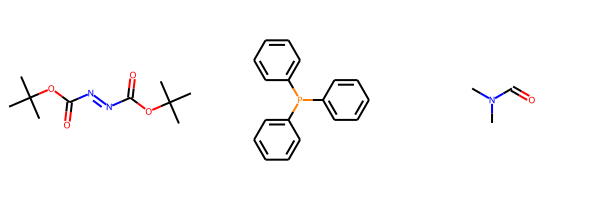

In [10]:
bo.reaction.visualize(0)

## Initialization

In keeping with our paper, we will start the optimization campaign by randomly selecting experiments. We made this choice when we instantiated the optimizer when we specified ```init_method='rand'```. We can then export the proposed experiments to a CSV file and fill in the results once we run the experiments.


In [11]:
bo.init_sample(seed=0)             # Initialize
bo.export_proposed('init.csv')     # Export design to a CSV file
bo.get_experiments()               # Print selected experiments

,azadicarboxylate_SMILES_index,phosphine_SMILES_index,solvent_SMILES_index,substrate_concentration_index,azadicarb_equiv_index,phos_equiv_index,temperature_index
91036,O=C(OCC1=CC=CC=C1)/N=N/C(OCC2=CC=CC=C2)=O,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,CC#N,0.05,1.3,1.5,15
59238,CC(OC(/N=N/C(OC(C)C)=O)=O)C,CN(C1=CC=C(P(C2=CC=CC=C2)C3=CC=CC=C3)C=C1)C,CC1=CC=CC=C1,0.10,1.9,1.5,35
149078,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CN(C1=CC=C(P(C2=CC=CC=C2)C3=CC=CC=C3)C=C1)C,CC1=CC=CC=C1,0.05,1.7,1.1,35
31550,CC(OC(/N=N/C(OC(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,CC1=CC=CC=C1,0.05,1.5,1.1,5
155877,CN(C(/N=N/C(N(C)C)=O)=O)C,CP(C1=CC=CC=C1)C2=CC=CC=C2,C1CCOC1,0.20,1.1,1.1,25
4063,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,CCCCP(CCCC)CCCC,CC1=CC=CC=C1,0.05,1.5,1.5,35
143560,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CC1=CC=C(P(C2=CC=CC=C2)C3=CC=CC=C3)C=C1,CC#N,0.05,1.5,1.5,5
18630,CC(C)(OC(/N=N/C(OC(C)(C)C)=O)=O)C,C1(P(C2CCCCC2)C3CCCCC3)CCCCC1,CC#N,0.10,1.1,1.3,5
136420,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CC1=CC=C(P(C2=CC=C(C=C2)C)C3=CC=C(C=C3)C)C=C1,CC#N,0.20,1.3,1.9,5
152336,CN(C(/N=N/C(N(C)C)=O)=O)C,C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1,CC(OCC)=O,0.15,1.7,1.5,15


Since we ran this optimization over a few days it was advantageous to save the BO instance for later. That way we didn't have to rebuild the reaction space and reinstantiate the BO object if we close the kernel. The ```edbo.bro.BO.save()``` method will pickle the optimizer for later.

In [12]:
bo.save()

Once we have saved the optimizer workspace we can load it by calling ```edbo.bro.BO.load()```.

In [13]:
from edbo.bro import BO_express

bo = BO_express()
bo.load()

## Bayesian Optimization Loop

Now that we have defined the reaction space and optimizer, we can iteratively run the optimizer to select experiments, evaluate the experiments in the lab, and read in the results as CSV files. In this case, we ran the experiments selected at random above. We can load the data using the ```edbo.bro.BO_express.add_results``` method.


In [14]:
bo.add_results('results/init.csv')

Next in the BO loop, we fit the surrogate model (by default ```edbo.models.GP_Model```) and optimize the acquisition function (we selected expected improvement at instantiation with ```acquisition_function='EI'```) to select the next experiments to run. This is accomplished with the ```edbo.bro.BO.run``` method. This method returns the encoded domain points for the selected experiments and stores them in ```edbo.bro.BO.proposed_experiments```.

In [15]:
bo.run()

,azadicarboxylate_number_of_atoms_MING,azadicarboxylate_dipole_MING,azadicarboxylate_dipole_Boltz,azadicarboxylate_molar_mass_MING,azadicarboxylate_molar_volume_MING,azadicarboxylate_lumo_energy_MING,azadicarboxylate_hardness_MING,azadicarboxylate_hardness_Boltz,azadicarboxylate_E_scf_MING,azadicarboxylate_ES_root_molar_volume_MING,...,solvent_c_min+1_NMR_shift,solvent_c_max_Mulliken_charge,solvent_c_max_NMR_shift,solvent_c_max_ES_root_Mulliken_charge,solvent_c_min_%VBur,solvent_c_min+1_%VBur,substrate_concentration,azadicarb_equiv,phos_equiv,temperature
155999,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,1.0,1.0,1.00
65878,0.857143,1.000000,1.000000,1.000000,1.000000,0.000000,0.369550,0.447016,0.000000,0.954961,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,0.0,0.75
155500,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,0.0,0.0,0.0,0.00
125879,1.000000,0.000000,0.092534,0.410916,0.721708,1.000000,0.000000,0.135560,0.826069,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,0.0,1.00
153379,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,0.0,1.00
155379,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,0.961782,0.584865,0.126492,0.404132,0.028900,1.000000,1.0,0.0,0.0,1.00
5875,0.714286,0.000096,0.655230,0.297828,0.583642,0.748221,1.000000,1.000000,0.853246,0.378844,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,0.0,0.00
155895,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,1.0,0.00
155879,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,0.0,0.0,1.00
155975,0.000000,0.000216,0.000000,0.000000,0.000000,0.782918,0.002144,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.721064,0.745407,1.0,1.0,0.0,0.00


Once we have used the run method, we can carry out miscellaneous analysis using some built in methods. For example, we can track the convergence of the optimizer (obviously not interesting here).

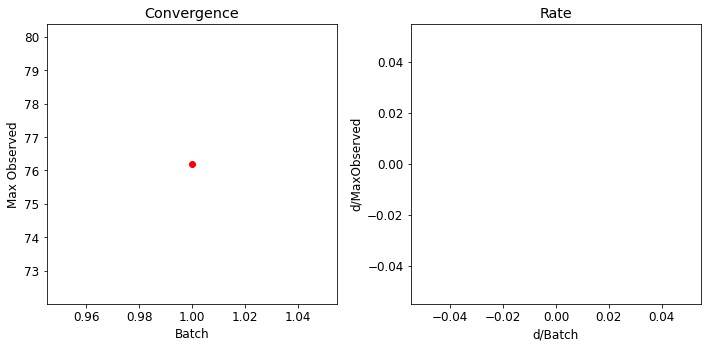

In [16]:
bo.plot_convergence()

We can see how well the surrogate model fits the available data.

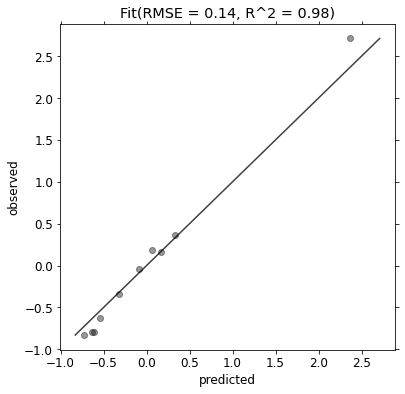

In [17]:
bo.model.regression()

We can also crack open the optimizer and check out what is happening under the hood by writing some custom analysis functions. For example, we can plot a 1D projection of the parallel acquisition function's choices (For EI batching is accplished with ```edbo.acq_func.Kriging_believer```).

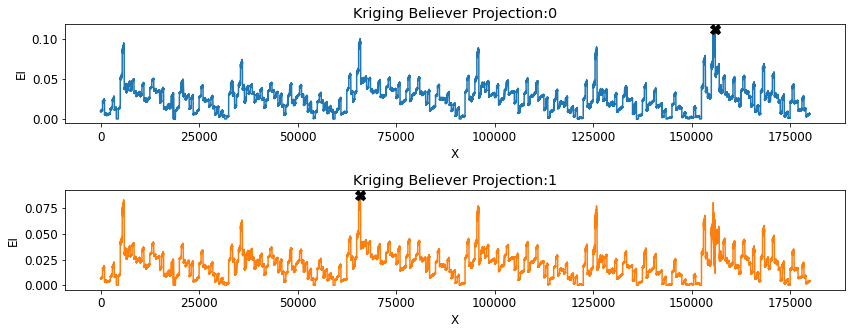

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kb_projections(n=2):
    """
    Plot 1D projection of Kriging believer parallel batch selection algorithm.
    """

    fig, ax = plt.subplots(len(bo.acq.function.projections[:n]),1, figsize=(12, n * 12 / 5))
    for i, p in enumerate(bo.acq.function.projections[:n]):
        ax[i].plot(range(len(p)), p, color='C' + str(i))
        ax[i].plot([np.argmax(p)], p[np.argmax(p)], 'X', markersize=10, color='black')
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('EI')
        ax[i].set_title('Kriging Believer Projection:' + str(i))
    
    plt.tight_layout()
    plt.show()
    
plot_kb_projections()

Back to the main task – optimizing this Mitsunobu reaction. Now we can export the next round of experiments as a CSV file, run the experiments, fill in the CSV, and iterate.

In [19]:
bo.export_proposed('round0.csv')

Let's say we are happy with this workflow and want to carry out the same analysis in each round. We can wrap each of these steps up into a simple function.

In [20]:
def workflow(export_path):
    """
    Function for our BO pipeline.
    """
    
    bo.run()
    bo.plot_convergence()
    bo.model.regression()
    plot_kb_projections()
    bo.export_proposed(export_path)

And run the same analysis for each round.

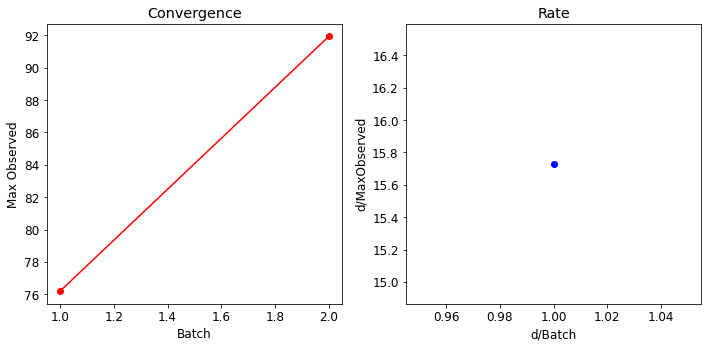

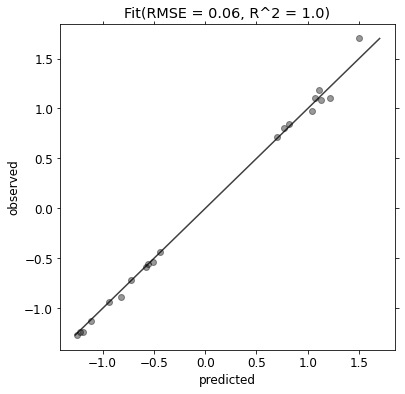

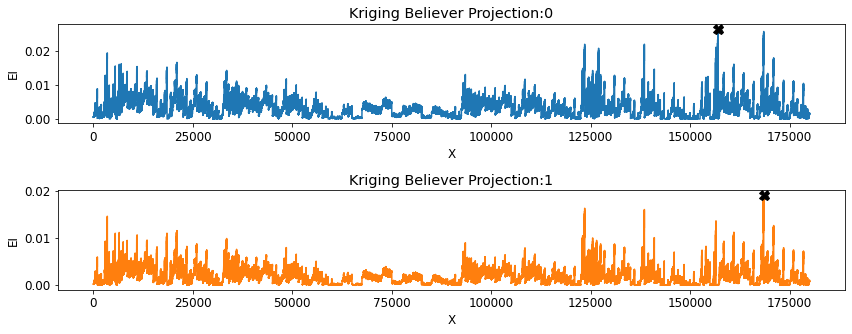

In [21]:
bo.add_results('results/round0.csv')       # Load real results from our experiments
workflow('round1.csv')                     # Run the workflow and export the next experiments to 'round1.csv'

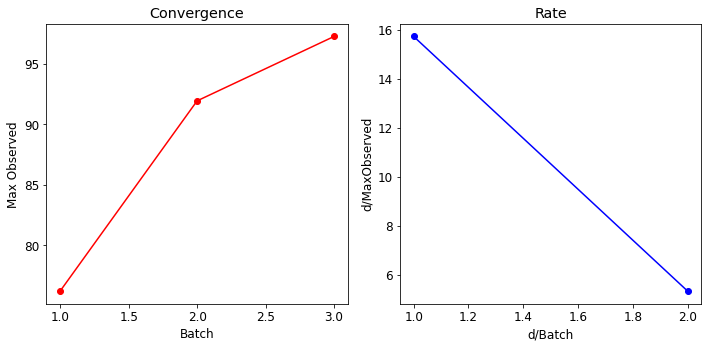

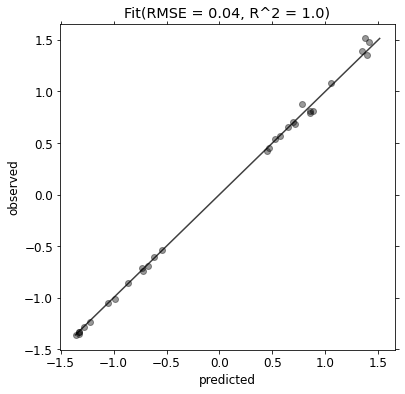

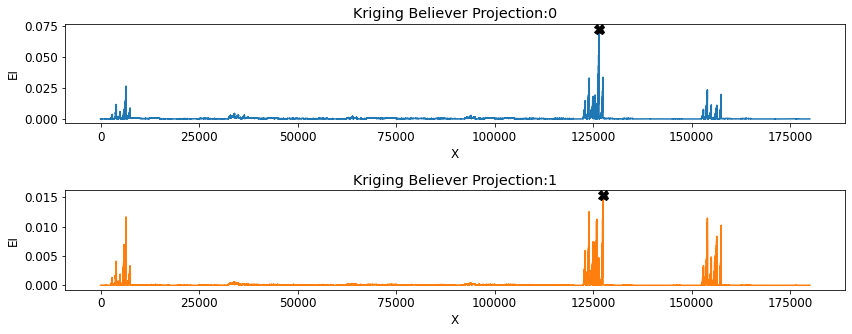

In [22]:
bo.add_results('results/round1.csv')       # Load real results from our experiments
workflow('round2.csv')                     # Run the workflow and export the next experiments to 'round2.csv'

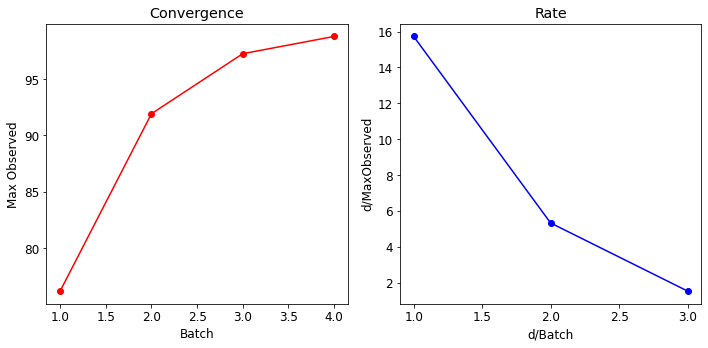

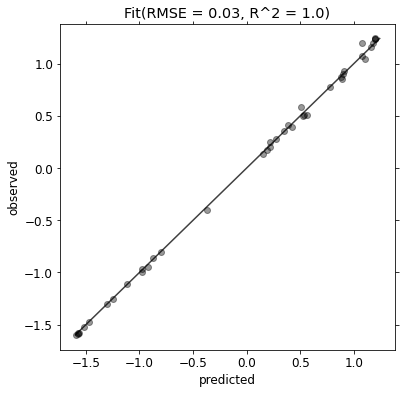

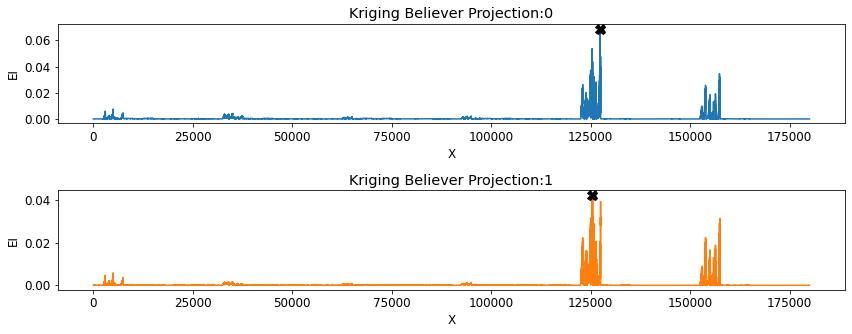

In [23]:
bo.add_results('results/round2.csv')       # Load real results from our experiments
workflow('round3.csv')                     # Run the workflow and export the next experiments to 'round3.csv'

Awesome, so in 4 rounds of 10 experiments we have hit essentially quantitative yield for this reaction. Once you have the data you can do whatever analysis your heart desires. Let’s just check out the conditions for the best yielding reactions.

In [24]:
results = pd.DataFrame(columns=bo.reaction.index_headers + ['yield'])
for path in ['init', 'round0', 'round1', 'round2']:
    results = pd.concat([results, pd.read_csv('results/' + path + '.csv', index_col=0)], sort=False)

results = results.sort_values('yield', ascending=False)
results.head()

,azadicarboxylate_SMILES_index,phosphine_SMILES_index,solvent_SMILES_index,substrate_concentration_index,azadicarb_equiv_index,phos_equiv_index,temperature_index,yield
125997,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CP(C1=CC=CC=C1)C2=CC=CC=C2,C1CCOC1,0.20,1.9,1.9,25,98.786244
156374,CN(C(/N=N/C(N(C)C)=O)=O)C,CP(C1=CC=CC=C1)C2=CC=CC=C2,CC#N,0.15,1.9,1.9,45,98.747640
125874,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CP(C1=CC=CC=C1)C2=CC=CC=C2,C1CCOC1,0.15,1.9,1.9,45,98.531481
127499,O=C(N1CCCCC1)/N=N/C(N2CCCCC2)=O,CP(C1=CC=CC=C1)C2=CC=CC=C2,CC(OCC)=O,0.20,1.9,1.9,45,97.435627
155974,CN(C(/N=N/C(N(C)C)=O)=O)C,CP(C1=CC=CC=C1)C2=CC=CC=C2,C1CCOC1,0.20,1.7,1.9,45,97.256471


Plot a bar chart for parameter frequency in the top 5 yielding reactions.

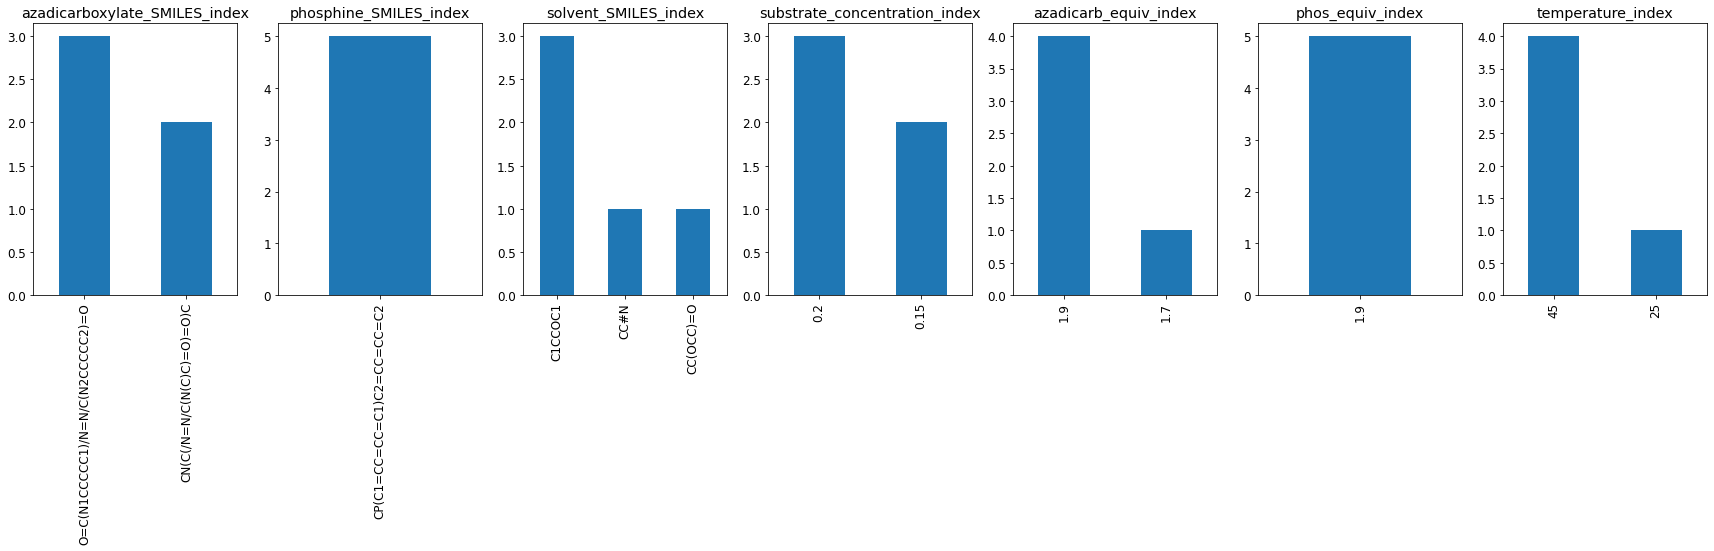

In [25]:
fig, ax = plt.subplots(1, len(results.columns.values[:-1]), figsize=(30,5))

for i, feature  in enumerate(results.columns.values[:-1]):
    results[feature].iloc[:5].value_counts().plot(kind="bar", ax=ax[i]).set_title(feature)
plt.show()

Visualize the reagents in the top 5 yielding reactions using ```edbo.chem_utils.ChemDraw```.


Component: azadicarboxylate_SMILES_index 



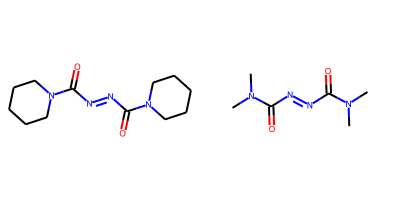


Component: phosphine_SMILES_index 



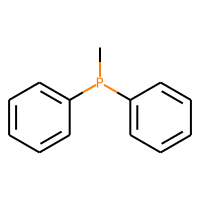


Component: solvent_SMILES_index 



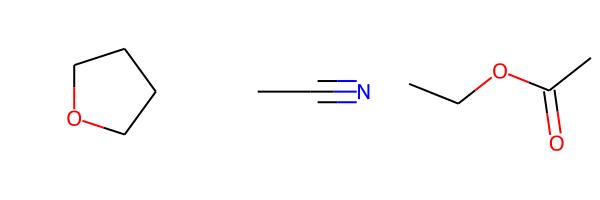

In [26]:
from edbo.chem_utils import ChemDraw

for col in results.iloc[:,:3].columns.values:
    print('\nComponent:', col, '\n')
    cdx = ChemDraw(results[col].iloc[:5].drop_duplicates())
    cdx.show()

Total compute time on my laptop (i7-6500U): 8 min 38 s